In [113]:
import pandas as pd
import numpy as np
import networkx as nx
import hydrant.topology.geom as gm
import matplotlib.pyplot as plt
from typing import (
    Union,
    List
)
from __future__ import annotations

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import subprocess
import os
from   shapely.geometry import Point

def find_upstream(
    gdf: gpd.GeoDataFrame,
    target_id: Union[str, int, ...],
    main_id: str,
    ds_main_id: str,
) -> set[...]:
    '''Find "ancestors" or upstream segments in a river network given
    in the from of a geopandas.GeoDataFrame `gdf`
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame of river segments including at least three pieces
        of information: 1) geometries of segments, 2) segment IDs, and
        3) downstream segment IDs
    target_id: str, int, or any other data type as included in `gdf`
        Indicating the target ID anscestor or upstream of which is
        desired
    main_id: str
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    
    Returns
    -------
    nodes: list
        IDs of nodes being upstream or anscestor of the `target_id`
    
    '''
    # creating a DiGraph out of `gdf` object
    riv_graph = nx.from_pandas_edgelist(gdf,
                                        source=main_id,
                                        target=ds_main_id,
                                        create_using=nx.DiGraph)

    # return nodes in a list
    nodes = nx.ancestors(riv_graph, target_id)

    # adding `target_id` as the last node of the branch
    nodes.add(target_id)

    return nodes

def main_branch(df, df_info):
    
    # get the values
    id_name     = df_info.get('id')
    next_name   = df_info.get('next')
    uparea_name = df_info.get('uparea')
    area_name   = df_info.get('area')
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges and assign upa as edge weight
    for _, row in df.iterrows():
        G.add_edge(row[next_name], row[id_name], weight=row[uparea_name])
        
    # get the longest distance weighted based on up area
    longest_path = nx.dag_longest_path(G, weight='weight')

    #print("Longest distance:", longest_path)
    
    # Set flag to 1 where id is in the array_to_check
    df['main_branch'] = 0
    df.loc[df[id_name].isin(longest_path), 'main_branch'] = 1
    
    return df

def pfaf_one_round(df, df_info):
    
    # get the values
    id_name     = df_info.get('id')
    next_name   = df_info.get('next')
    uparea_name = df_info.get('uparea')
    area_name   = df_info.get('area')
    
    # add the pfaf_temp and get the main branch
    df['pfaf_temp'] = 1
    df = main_branch(df, df_info)
    
    # Separate DataFrame based on flag value
    df_main      = df[df['main_branch'] == 1].sort_values(by=uparea_name, ignore_index=True)
    
    if len(df) != len(df_main):
        
        # identify 4 largest upstream segments to main branch
        df_none_main = df[df['main_branch'] == 0].sort_values(by=uparea_name, ignore_index=True, ascending=False)
        max_4_up = df_none_main.loc[df_none_main[next_name].isin(df_main[id_name])].head(4)
        max_4_up = max_4_up.sort_values(by=uparea_name, ignore_index=True)

        # attach the uparea of the next down ID, which are on main ID, to the max_4_up dataframe
        max_4_up['next_up_area'] = 0
        max_4_up['up_confluence_main_id'] = 0
        for index, row in max_4_up.iterrows():
            # get the up area of df_main that is downstream of max_4_up
            max_4_up.loc[index,'next_up_area'] = df_main[uparea_name].loc[df_main[id_name]==row[next_name]].values
            index_temp = df_main.loc[df_main[id_name]==row[next_name]].index-1
            index_temp = np.array(index_temp).item()
            max_4_up.loc[index,'up_confluence_main_id'] = df_main[id_name].loc[index_temp] 

        max_4_up = max_4_up.sort_values(by='next_up_area', ignore_index=True)
        
        #print(max_4_up)
        
        if max_4_up.empty:
            raise ValueError("Error: max_4_up is empty")

        # get the len of max_4_up unique elements
        if len(np.unique(max_4_up[next_name])) == 4:
            odd_pfafs = [3,5,7,9]
        elif len(np.unique(max_4_up[next_name])) == 3:
            odd_pfafs = [3,5,9]
        elif len(np.unique(max_4_up[next_name])) == 2:
            odd_pfafs = [3,9]
        elif len(np.unique(max_4_up[next_name])) == 1:
            odd_pfafs = [9]

        # get the len of max_4_up elements
        if len(max_4_up[next_name]) == 4:
            even_pfafs = [2,4,6,8]
        elif len(max_4_up[next_name]) == 3:
            even_pfafs = [2,4,6]
        elif len(max_4_up[next_name]) == 2:
            even_pfafs = [2,4]
        elif len(max_4_up[next_name]) == 1:
            even_pfafs = [2]

        # add the segment and station into a data frame
        seg_ids = np.array([])
        pfaf_codes = np.array([])

        # Add values to the array for main branch
        seg_ids = np.append(seg_ids, max_4_up['up_confluence_main_id'])
        pfaf_codes = np.append(pfaf_codes, np.flip(odd_pfafs, axis=0))

        # add values to array for tributaries
        seg_ids = np.append(seg_ids, max_4_up[id_name])
        pfaf_codes = np.append(pfaf_codes, np.flip(even_pfafs, axis=0))
        zipped = zip(seg_ids, pfaf_codes)
        sorted_zipped = sorted(zipped, key=lambda x: x[1])

        # get the upstream and assign the pfaf from smaller values to largest values
        df['pfaf_temp'] = 1

        for seg_id, pfaf_code in sorted_zipped:
            ids_selected = find_upstream(df, seg_id, id_name, next_name)
            # replace the ids in df
            indices = df[df[id_name].isin(ids_selected)].index
            # Update 'flag' column to 1 for the rows with matching indices
            df.loc[indices, 'pfaf_temp'] = pfaf_code

    return df


def find_separated_graphs(df, df_info):
    
    # get the values
    id_name     = df_info.get('id')
    next_name   = df_info.get('next')
    
    # Create a graph from the dataframe
    G = nx.from_pandas_edgelist(df, id_name, next_name)

    # Find connected components in the graph
    connected_components = list(nx.connected_components(G))

    # Map each node to its connected component
    node_to_component = {}
    for i, component in enumerate(connected_components, 1):
        for node in component:
            node_to_component[node] = i

    # Create a new column in the dataframe indicating the component number
    df['graph_number'] = df[id_name].map(node_to_component)

    return df


def transform_array(arr):
    # Find the maximum value in the array
    max_value = np.max(arr)
    
    # Determine the number of digits in the maximum value
    num_digits = len(str(max_value))
    
    # Calculate the multiplier
    multiplier = 10 ** num_digits
    
    # Transform the array
    transformed_arr = arr * multiplier
    
    return transformed_arr


def pfaf_sub(df, df_info = {'id':'COMID', 'next':'NextDownID', 'uparea': 'uparea', 'area': 'unitarea'}, depth = 10):
    
    # get the values
    id_name     = df_info.get('id')
    next_name   = df_info.get('next')
    uparea_name = df_info.get('uparea')
    area_name   = df_info.get('area')
    
    # get the current order based on id to sort later
    order_id = df[id_name].values
    
    # initial pfaf set up for the df
    df = pfaf_one_round (df, df_info=df_info)
    df['pfaf'] = df['pfaf_temp']
    
    for i in np.arange(2, depth):
        if len(df) != len(np.unique(df ['pfaf'])):
            df_slice_total = pd.DataFrame()
            for m in np.unique(df ['pfaf']):
                df_slice = df[df['pfaf']==m]
                df_slice = pfaf_one_round(df_slice, df_info)
                df_slice_total = pd.concat([df_slice_total,df_slice], ignore_index=True)
            df = df_slice_total.copy()
            #print(df)
        else:
            df['pfaf_temp'] = 0

        # Convert values in column1 and column2 to strings
        df['pfaf'] = df['pfaf'].astype(str)
        df['pfaf_temp'] = df['pfaf_temp'].astype(str)

        # Concatenate the strings in column1 and column2
        df['pfaf'] = df['pfaf'] + df['pfaf_temp']

        # Convert the concatenated string back to integers
        df['pfaf'] = df['pfaf'].astype(int)
        
        # set back to the original order
        df = df.set_index(id_name).loc[order_id].reset_index()
        
    return df



def pfaf(df, df_info = {'id':'COMID', 'next':'NextDownID', 'uparea': 'uparea', 'area': 'unitarea'}, depth = 10):
    
    # get the values
    id_name     = df_info.get('id')
    next_name   = df_info.get('next')
    uparea_name = df_info.get('uparea')
    area_name   = df_info.get('area')
    
    # get the current order based on id to sort later
    order_id = df[id_name].values
    
    # replace the possible 0 and negative values for nextid for networkx
    arr = np.array(df[next_name].values)
    max_value = arr.max() + 1
    for i in range(len(arr)):
        if arr[i] <= 0:
            arr[i] = max_value
            max_value += 1
    df[next_name] = arr
    
    # get separated regions
    df = find_separated_graphs(df, df_info)
    df ['pfaf_region'] = transform_array(df ['graph_number'].values)
    df = df.drop(columns= ['graph_number'])
    print(np.unique(df['pfaf_region'].values))
    
    # loop over separated regions
    df_all = pd.DataFrame()
    for i in np.unique(df['pfaf_region'].values):
        # slice the shapefile
        df_slice = df[df['pfaf_region']==i]
        df_slice = pfaf_sub(df_slice, df_info, depth)
        df_all = pd.concat([df_slice,df_all], ignore_index=True)
        
    # get the df in order
    df = df_all.set_index(id_name).loc[order_id].reset_index()    
    
    # drop the extra columns
    df = df.drop(columns=['pfaf_temp','main_branch'])
        
    return df

In [105]:
# Example data
data = {
    'id':   [1, 2, 3, 4,  5,  6,  7],
    'next': [3, 3, 5, 5,  7,  7,  8],
    'a':    [2, 3, 1, 6,  2,  7,  7],
    'upa':  [2, 3, 6, 6, 14,  7, 28]
}

data = {
    'id':   [ 9, 10, 11, 12, 13,109,110,111,112,113],
    'next': [11, 11, 13, 13, 14,111,111,113,113,114],
    'a':    [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
    'upa':  [ 7,  7, 14,  7, 21,  7,  7, 14,  7, 21]
}

# data = {
#     'id':   [10, 11, 12],
#     'next': [11, 13, 13],
#     'a':    [7,   7,  7],
#     'upa':  [7,  14, 21]
# }

# Create DataFrame
df = pd.DataFrame(data)

df = pfaf(df, df_info = {'id':'id', 'next':'next', 'uparea': 'upa', 'area': 'a'}, depth=3)

df

[10 20]


NameError: name 'll' is not defined

## Real case example

In [32]:
# inputs
path_out = './output/'
pfafs = ['71'] # 71 Saskatchewan, 78 Colombia
# riv_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
# cat_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
# cst_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'
riv_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cat_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cst_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cst_file_template = 'hillslope_*_clean.shp'

In [33]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [34]:
riv, cat = gm.merit_read_file (pfafs,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template,
                               path_cst = cst_path,
                               cst_file_template = cst_file_template)

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


# prepare the network topology

In [35]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                            cat=cat,\
                            cat_cols={'id':'COMID', 'hillslope':'hillslope', 'area' :'unitarea'},\
                            network = 'merit')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:491: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:492: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


# Example-3 From basins of identified pfafs that intersect with target stations in Alberta

In [36]:
# set the case name
prefix = 'stations_merit_'

In [107]:
data = {
    'Station ID': ['05BH004'],
    'seg ID': [71027942],
    'Station name': [
        'BOW RIVER AT CALGARY',
    ],
    'up': [0],
    'X': [-114.05],
    'Y': [  51.05]
}

data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [71028039, 71027942, 71034975, 71022153],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0],
    'X': [-115.03,-114.05,-113.86,-113.82],
    'Y': [51.11,    51.05,  50.58,  52.27]
}

# data = {
#     'Station ID': ['05BH004'],
#     'seg ID': [71028039],
#     'Station name': [
#         'BOW RIVER AT CALGARY',
#     ],
#     'up': [0],
#     'X': [-114.05],
#     'Y': [  51.05]
# }

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [108]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



<AxesSubplot:>

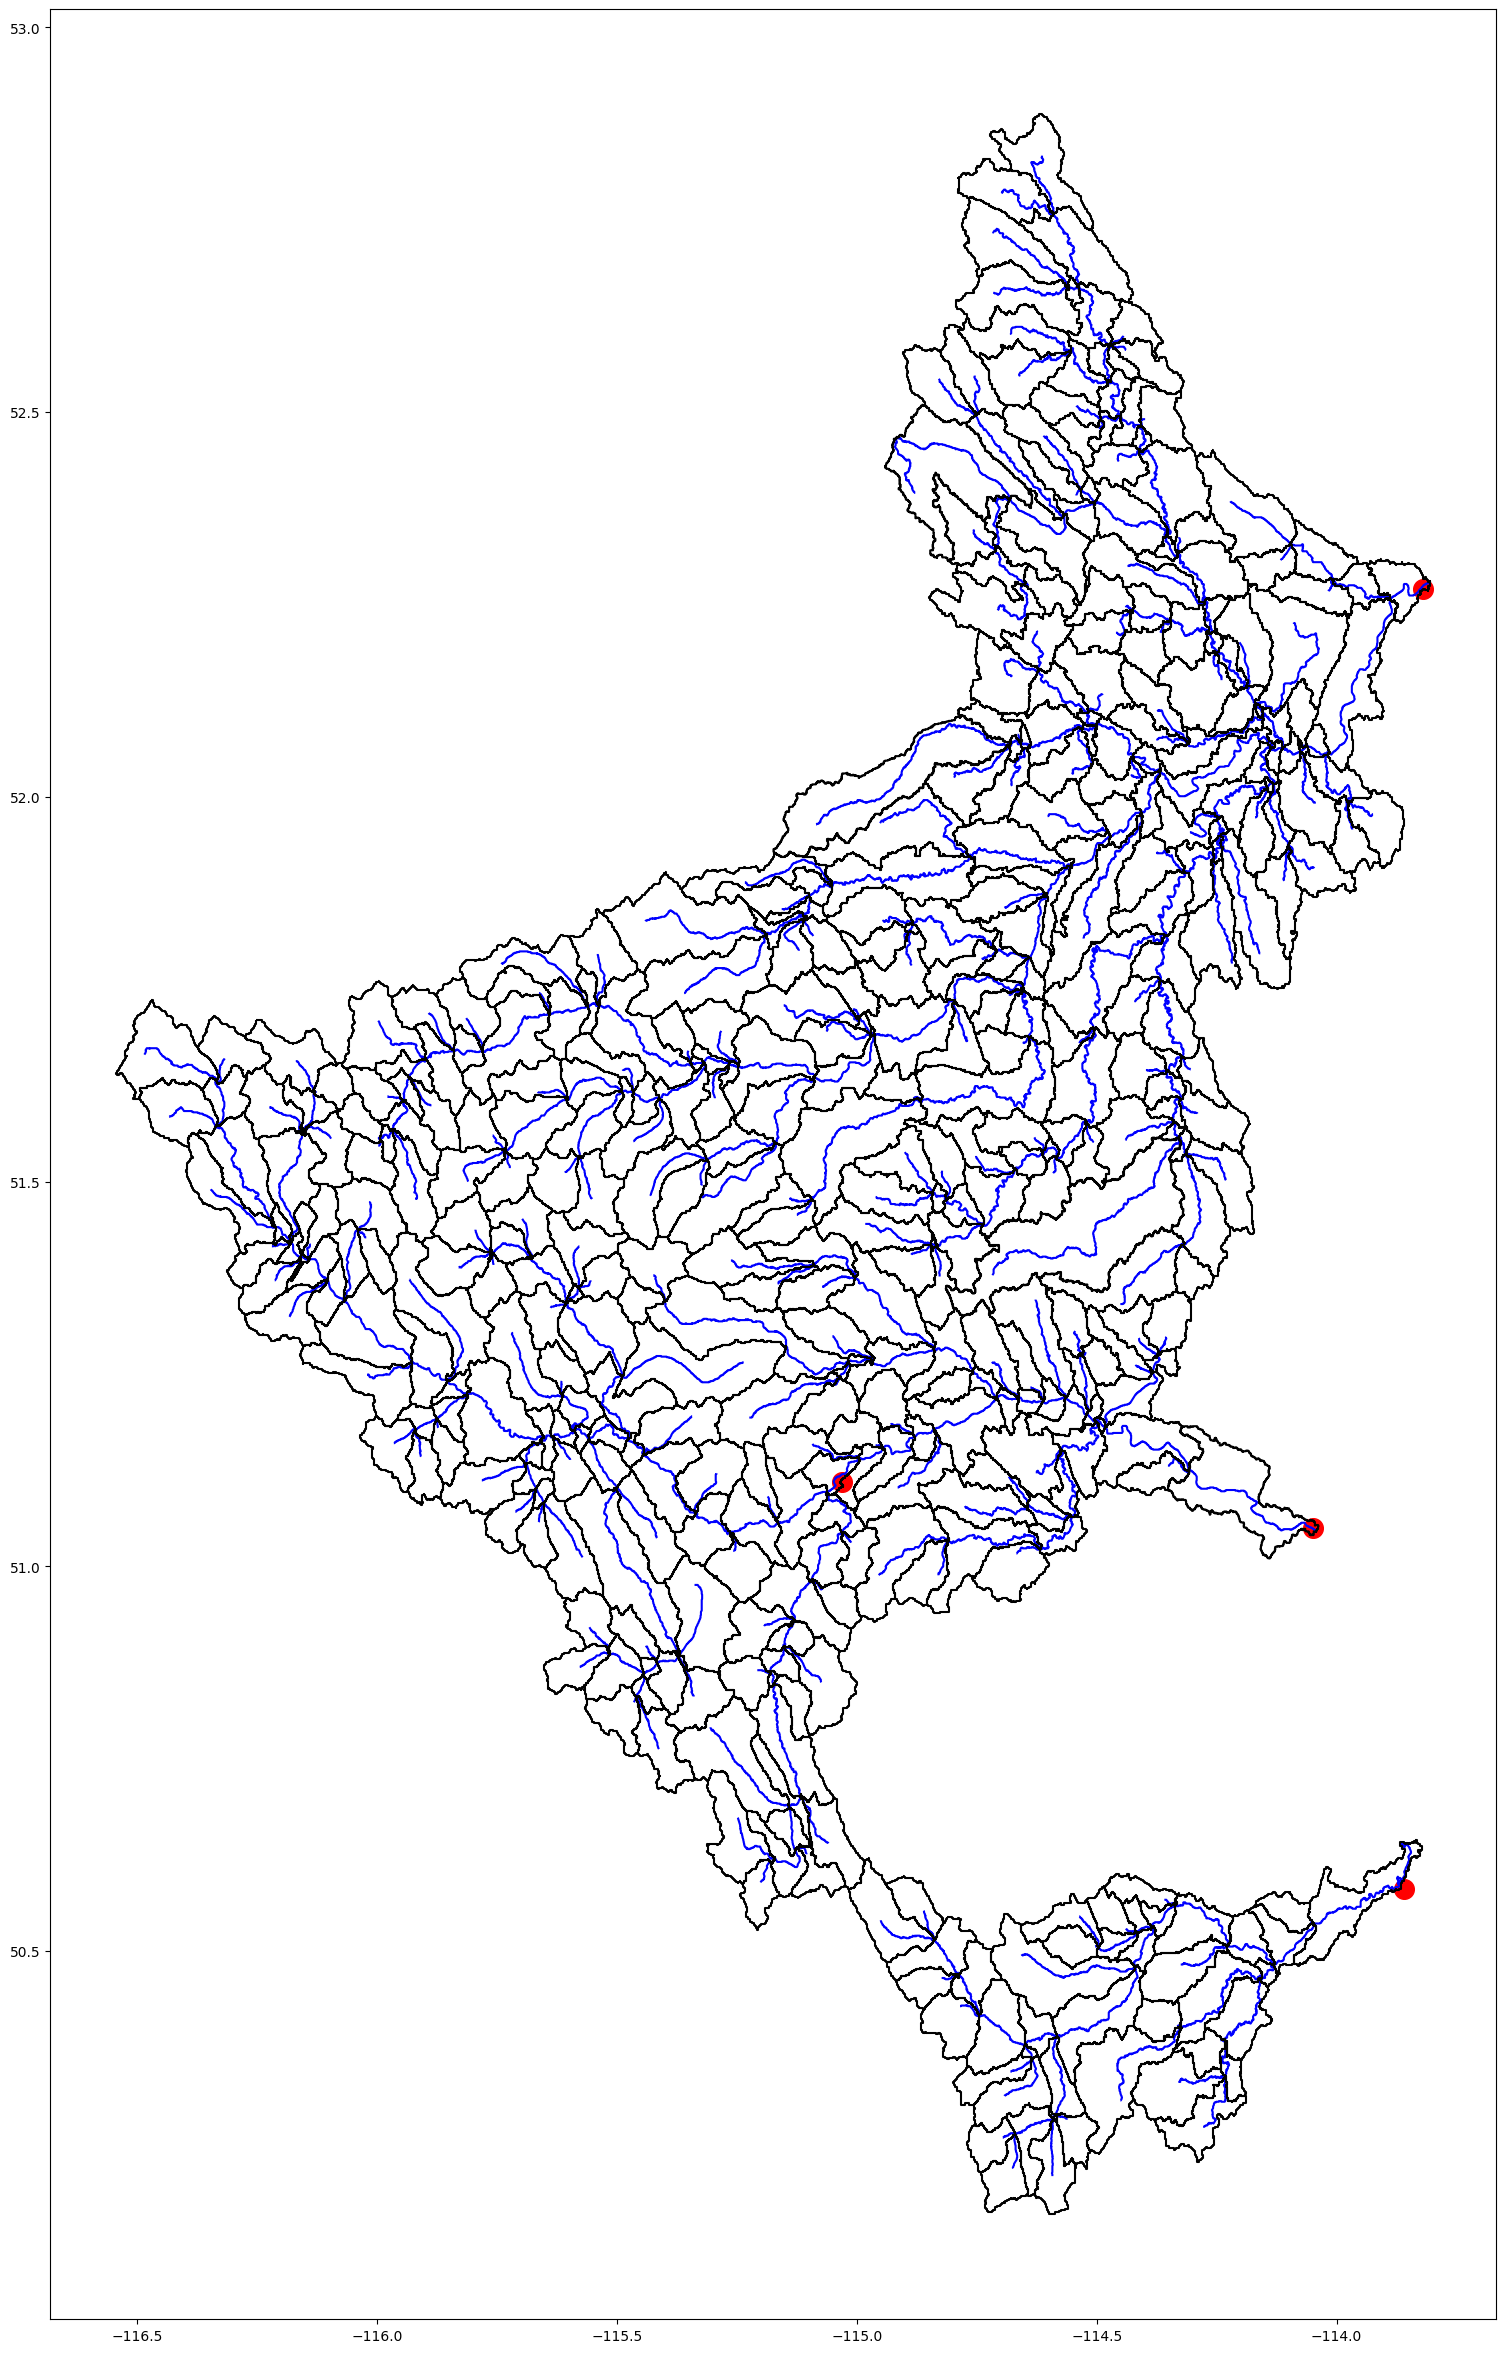

In [109]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [110]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
xr_ntopo

<xarray.Dataset>
Dimensions:     (n: 453)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 ... 445 446 447 448 449 450 451 452
Data variables: (12/20)
    COMID       (n) int64 71022153 71022160 71022164 ... 71039250 71039266
    length      (n) float64 9.651e+03 3.002e+04 ... 2.518e+03 1.198e+04
    lengthdir   (n) float64 6.073 23.71 3.242 1.22 ... 4.938 4.428 2.041 10.24
    sinuosity   (n) float64 1.589 1.266 1.27 1.134 ... 1.277 1.25 1.234 1.17
    slope       (n) float64 0.0009722 0.0008482 0.0009692 ... 0.03278 0.005844
    uparea      (n) float64 1.172e+10 1.142e+10 ... 2.796e+07 1.137e+08
    ...          ...
    up4         (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    unitarea    (n) float64 4.133e+07 1.358e+08 1.1e+07 ... 2.796e+07 1.137e+08
    latitude    (n) float64 52.28 52.15 52.07 52.06 ... 50.93 50.92 50.95 50.94
    longitude   (n) float64 -113.9 -114.0 -114.0 -114.1 ... -115.2 -115.0 -115.3
    width       (n) float64 109.3 107.9 106.6 106.5 ... 7.48 8.218 6.288 11.66

In [114]:
#riv_slice = riv_slice.rename(columns={'COMID': 'id', 'NextDownID': 'next', 'uparea': 'upa', 'unitarea': 'a'})
#cat_slice = cat_slice.rename(columns={'COMID': 'id'})

# caclulate pfaf for riv_slice
riv_slice = pfaf(riv_slice, df_info = {'id':'COMID', 'next':'NextDownID', 'uparea': 'uparea', 'area': 'unitarea'})

[10 20 30]


/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to b

<AxesSubplot:>

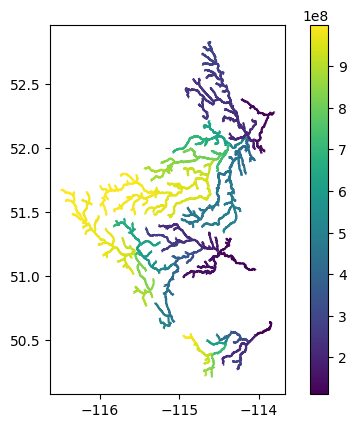

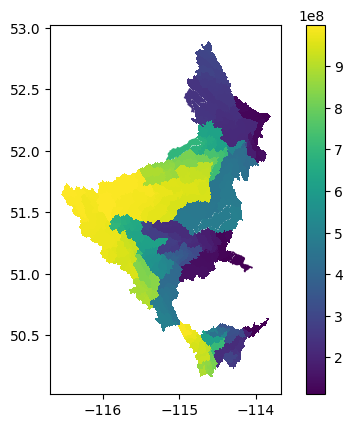

In [115]:
# pass pfaf to cat_slice
cat_slice['pfaf'] = riv_slice['pfaf']


# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)

# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
cat_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)

In [116]:
riv_slice

,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,...,geometry,hillslope,unitarea,latitude,longitude,width,pfaf_region,pfaf_temp,main_branch,pfaf
0,71022153,9.650666,6.073232,1.589049,0.000972,11718.725317,5,9.4,0.000972,71036467,...,"LINESTRING (-113.80500 52.27750, -113.80583 52...",0,41.328822,52.276063,-113.868966,109.253061,10,0,1,111100000
1,71022160,30.018433,23.706825,1.266236,0.000848,11420.248116,5,25.5,0.000848,71022153,...,"LINESTRING (-113.88750 52.25667, -113.88833 52...",0,135.786701,52.153275,-113.963718,107.865561,10,0,1,131100000
2,71022164,4.117765,3.242409,1.269971,0.000969,11158.223079,5,4.0,0.000969,71022160,...,"LINESTRING (-114.01500 52.05833, -114.01583 52...",0,11.004652,52.071025,-114.040900,106.632491,10,0,1,151100000
3,71022165,1.382913,1.219617,1.133891,0.000505,11121.798002,5,0.7,0.000505,71022164,...,"LINESTRING (-114.06083 52.06583, -114.06167 52...",0,1.473209,52.062767,-114.069721,106.459936,10,0,1,171100000
4,71022168,3.820904,2.549164,1.498885,0.000810,11050.683368,5,3.1,0.000810,71022165,...,"LINESTRING (-114.07500 52.05917, -114.07583 52...",0,11.729645,52.054057,-114.096759,106.122231,10,0,1,191100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,71039048,3.473762,2.989757,1.161888,0.036308,30.339439,1,126.3,0.036308,71035979,...,"LINESTRING (-115.41583 50.87417, -115.41667 50...",0,30.339439,50.912529,-115.465044,6.508125,20,0,1,872100000
449,71039109,6.307484,4.937584,1.277443,0.017588,41.987611,1,111.1,0.017588,71036389,...,"LINESTRING (-115.51417 50.88583, -115.51500 50...",0,41.987611,50.931672,-115.554518,7.479785,20,0,1,889100000
450,71039121,5.537017,4.428210,1.250396,0.028829,52.094426,1,160.0,0.028829,71035238,...,"LINESTRING (-115.13083 50.93000, -115.13167 50...",0,52.094426,50.917342,-115.216567,8.217647,20,0,1,421100000
451,71039250,2.518299,2.040736,1.234015,0.032782,27.957672,1,82.7,0.032782,71028304,...,"LINESTRING (-115.09500 50.98083, -115.09417 50...",0,27.957672,50.952414,-115.034746,6.287502,20,0,1,414100000


number of shape:  1


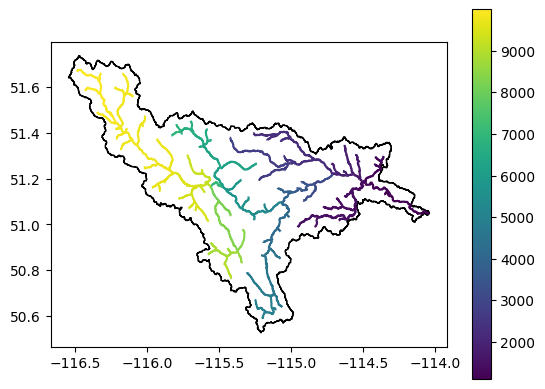

In [22]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=0):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

number of shape:  9


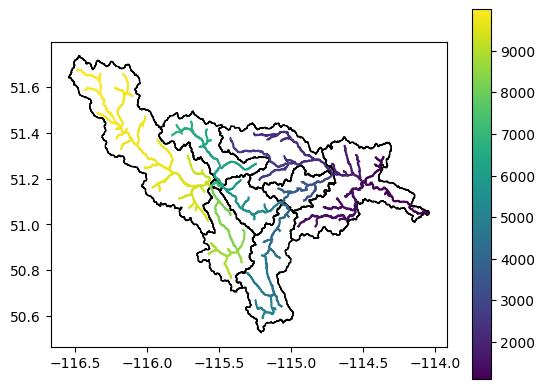

In [23]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=1):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

number of shape:  73


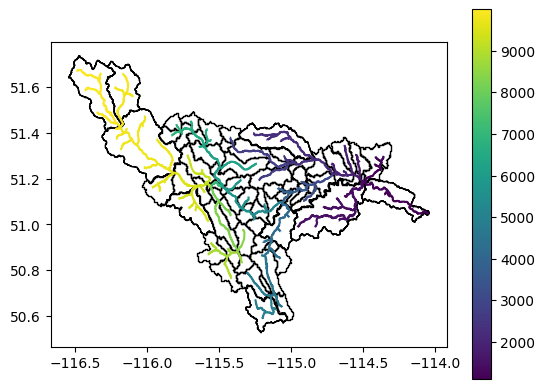

In [15]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=2):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

number of shape:  159


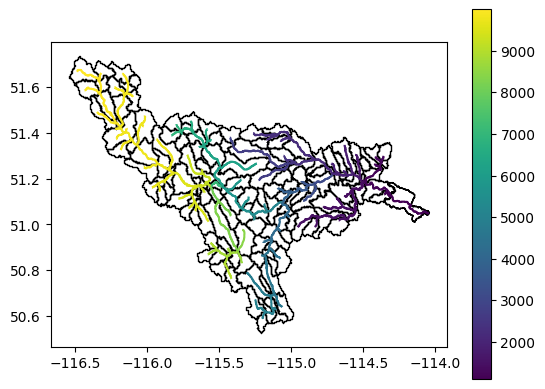

In [16]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=3):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

number of shape:  169


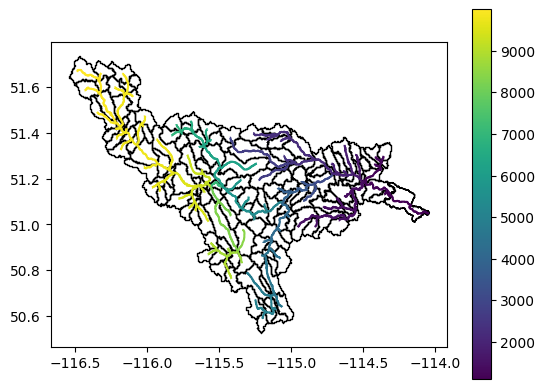

In [17]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=4):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

In [26]:
import networkx as nx

# Define the edges of the network
edges = [(1, 2), (2, 3), (3, 4), (6, 7), (7, 8), (9, 8)]

# Create a graph from the edges
G = nx.Graph(edges)

# Find connected components in the graph
connected_components = list(nx.connected_components(G))

# Print the number of separated graphs
print("Number of separated graphs:", len(connected_components))

# Print the elements of each graph
for i, component in enumerate(connected_components, 1):
    print("Graph", i, ":", component)

Number of separated graphs: 2
Graph 1 : {1, 2, 3, 4}
Graph 2 : {8, 9, 6, 7}


In [40]:
import numpy as np

def transform_array(arr):
    # Find the maximum value in the array
    max_value = np.max(arr)
    
    # Determine the number of digits in the maximum value
    num_digits = len(str(max_value))
    
    # Calculate the multiplier
    multiplier = 10 ** num_digits
    
    # Transform the array
    transformed_arr = arr * multiplier
    
    return transformed_arr

# Example usage:
arr = np.array([1, 2, 3, 4, 5, 11, 1100])
transformed_arr = transform_array(arr)
print(transformed_arr)

[   10000    20000    30000    40000    50000   110000 11000000]


In [101]:
import numpy as np

# Sample array
arr = np.array([1, 0, 3, -1, 2, -1, 3, -1])

# Initialize a dictionary to keep track of replacement values
max_value = arr.max() + 1
print(max_value)

# Iterate over the array and replace negative values with unique positive values
for i in range(len(arr)):
    if arr[i] <= 0:
        arr[i] = max_value
        max_value += 1

print(arr)

4
[1 4 3 5 2 6 3 7]
